In [5]:
%matplotlib inline

torchaudio를 사용한 음성 명령 분류
*********************************************

이 자습서에서는 오디오 데이터 세트를 올바르게 형식화한 다음 데이터 세트에서 오디오 분류자 네트워크를 훈련/테스트하는 방법을 보여줍니다.

Colab에는 GPU 옵션을 사용할 수 있습니다. 메뉴 탭에서 "런타임"을 선택한 다음 "런타임 유형 변경"을 선택합니다. 다음 팝업에서 GPU를 선택할 수 있습니다.
변경 후에는 런타임이 자동으로 다시 시작됩니다(즉, 실행된 셀의 정보가 사라짐).

먼저 다음과 같은 일반적인 토치 패키지를 가져옵니다.
웹사이트의 지침에 따라 설치할 수 있는 `torchaudio <https://github.com/pytorch/audio>`__.


In [6]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

CUDA GPU를 사용할 수 있는지 확인하고 장치를 선택해 보겠습니다. GPU에서 네트워크를 실행하면 교육/테스트 런타임이 크게 줄어듭니다.




In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


데이터세트 가져오기
---------------------

우리는 torchaudio를 사용하여 데이터 세트를 다운로드하고 나타냅니다. 여기에서 우리는 서로 다른 사람들이 말한 35개 명령의 데이터 세트인 `SpeechCommands <https://arxiv.org/abs/1804.03209>`__를 사용합니다. 데이터 세트 ``SPEECHCOMMANDS``는 데이터 세트의 ``torch.utils.data.Dataset`` 버전입니다. 이 데이터 세트에서 모든 오디오 파일의 길이는 약 1초입니다(따라서 약 16000시간 프레임 길이).

실제 로드 및 서식 지정 단계는 데이터 포인트가
액세스되고 있으며 torchaudio는 오디오 파일을 텐서로 변환하는 작업을 처리합니다. 대신 오디오 파일을 직접 로드하려면
``torchaudio.load()``를 사용할 수 있습니다. 다음을 포함하는 튜플을 반환합니다.
오디오 파일의 샘플링 주파수(SpeechCommands의 경우 16kHz)와 함께 새로 생성된 텐서.

데이터 세트로 돌아가서 여기에서 데이터 세트를 분할하는 하위 클래스를 만듭니다.
표준 교육, 검증, 테스트 하위 집합.




In [9]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

SPEECHCOMMANDS 데이터 세트의 데이터 포인트는 파형(오디오 신호), 샘플 속도, 발화(레이블), 화자의 ID, 발화 수로 구성된 튜플입니다.




In [12]:
label

'backward'

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


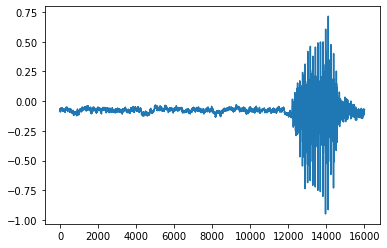

In [10]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [13]:
waveform.shape

torch.Size([1, 16000])

In [15]:
import IPython
IPython.display.Audio(waveform.numpy()[0], rate=sample_rate )

데이터세트에서 사용 가능한 라벨 목록을 찾아보겠습니다.




In [11]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

35개의 오디오 레이블은 사용자가 말하는 명령입니다. 처음 몇
파일은 "marvin"이라고 말하는 사람들입니다.



In [16]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)



In [18]:
waveform_second, *_ = train_set[1000]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

마지막 파일은 "시각적"이라고 말하는 사람입니다.




In [19]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

데이터 포맷
-------------------

이것은 데이터에 변환을 적용하기에 좋은 위치입니다. 을 위해
오디오를 다운샘플링하여 분류 능력을 너무 많이 잃지 않고 더 빠르게 처리합니다.

여기에 다른 변환을 적용할 필요가 없습니다. 채널 차원을 따라 평균을 취하거나 단순히 채널 중 하나만 유지하여 채널 수를 줄여야(예: 스테레오에서 모노로) 일부 데이터 세트의 경우 일반적입니다. SpeechCommands는 오디오에 단일 채널을 사용하므로 여기서는 필요하지 않습니다.



In [20]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

레이블 목록의 인덱스를 사용하여 각 단어를 인코딩하고 있습니다.




In [21]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


오디오 녹음 및 발화로 구성된 데이터 포인트 목록을 전환하려면
모델에 대한 두 개의 일괄 처리된 텐서로 데이터 집합을 일괄 처리할 수 있도록 하는 PyTorch DataLoader에서 사용하는 대조 기능을 구현합니다. 대조 기능 작업에 대한 자세한 내용은 `문서 <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__를 참조하세요.

대조 기능에서 리샘플링과 텍스트 인코딩도 적용합니다.




In [22]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

네트워크 정의
------------------

이 튜토리얼에서는 컨볼루션 신경망을 사용하여 처리합니다.
원시 오디오 데이터. 일반적으로 오디오 데이터에 고급 변환이 적용되지만 CNN을 사용하여 원시 데이터를 정확하게 처리할 수 있습니다.
특정 아키텍처는 M5 네트워크 아키텍처를 모델로 합니다.
`이 문서 <https://arxiv.org/pdf/1610.00087.pdf>`__에 설명되어 있습니다. 안
원시 오디오 데이터를 처리하는 모델의 중요한 측면은 첫 번째 레이어 필터의 수용 필드입니다. 우리 모델의 첫 번째 필터는 길이가 80이므로 8kHz로 샘플링된 오디오를 처리할 때 수용 필드는 약 10ms(4kHz에서는 약 20ms)입니다. 이 크기는 20ms에서 40ms 범위의 수용 필드를 자주 사용하는 음성 처리 응용 프로그램과 유사합니다.




In [45]:
x = torch.arange(8, dtype=torch.float32).reshape(1,1,8)
print(x.shape)
print(x)
conv1 = nn.Conv1d(1, 3, kernel_size=2, stride=1)
torch.nn.init.ones_(conv1.weight)
torch.nn.init.zeros_(conv1.bias)
pool1 = nn.MaxPool1d(3)

x = conv1(x)
print(x.shape)
print(x)
x = pool1(x) 
print(x.shape)
print(x)

torch.Size([1, 1, 8])
tensor([[[0., 1., 2., 3., 4., 5., 6., 7.]]])
torch.Size([1, 3, 7])
tensor([[[ 1.,  3.,  5.,  7.,  9., 11., 13.],
         [ 1.,  3.,  5.,  7.,  9., 11., 13.],
         [ 1.,  3.,  5.,  7.,  9., 11., 13.]]], grad_fn=<ConvolutionBackward0>)
torch.Size([1, 3, 2])
tensor([[[ 5., 11.],
         [ 5., 11.],
         [ 5., 11.]]], grad_fn=<SqueezeBackward1>)


In [23]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

논문에서 사용된 것과 동일한 최적화 기술인 가중치 감쇠가 0.0001로 설정된 Adam 옵티마이저를 사용할 것입니다. 처음에는 0.01의 학습률로 훈련하지만 20 epoch 이후 훈련 중에는 ``scheduler``를 사용하여 0.001로 낮출 것입니다.




In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

신경망 훈련 및 테스트
--------------------------------

이제 교육 데이터를 제공할 교육 함수를 정의해 보겠습니다.
모델에 삽입하고 역방향 전달 및 최적화 단계를 수행합니다. 학습을 위해 우리가 사용할 손실은 음의 로그 우도입니다. 그런 다음 각 에포크 후에 네트워크를 테스트하여 교육 중에 정확도가 어떻게 변하는지 확인합니다.




In [25]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

이제 학습 기능이 있으므로 테스트용 기능을 만들어야 합니다.
네트워크 정확도. 모델을 ``eval()`` 모드로 설정한 다음 테스트 데이터 세트에서 추론을 실행합니다. ``eval()``을 호출하면 네트워크의 모든 모듈에 있는 훈련 변수가 거짓으로 설정됩니다.
배치 정규화 및 드롭아웃 레이어와 같은 특정 레이어는 훈련 중에 다르게 동작하므로 이 단계는 올바른 결과를 얻는 데 중요합니다.




In [26]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

마지막으로 네트워크를 훈련하고 테스트할 수 있습니다. 우리는 네트워크를 훈련시킬 것입니다
10 epoch 동안 학습률을 낮추고 10 epoch 더 훈련합니다.
네트워크는 정확도를 확인하기 위해 각 시대 이후에 테스트됩니다.
훈련 중에 달라집니다.




In [28]:
log_interval = 20
n_epoch = 25

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|          | 0.005333333333333333/25 [00:00<11:56, 28.66s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.835306


  0%|          | 0.05866666666666665/25 [00:01<11:53, 28.62s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.763426


  0%|          | 0.11199999999999995/25 [00:03<11:44, 28.29s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.918388


  1%|          | 0.16533333333333344/25 [00:04<11:53, 28.74s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 1.040789


  1%|          | 0.218666666666667/25 [00:06<11:40, 28.27s/it]  

Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.784642


  1%|          | 0.27200000000000035/25 [00:07<11:40, 28.34s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.804039


  1%|▏         | 0.32533333333333336/25 [00:09<11:35, 28.18s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.959690


  2%|▏         | 0.3786666666666664/25 [00:10<11:36, 28.27s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.639575


  2%|▏         | 0.4319999999999994/25 [00:12<11:34, 28.29s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 0.787360


  2%|▏         | 0.4853333333333324/25 [00:13<11:42, 28.64s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.869964


  2%|▏         | 0.5386666666666662/25 [00:15<11:36, 28.48s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.884164


  2%|▏         | 0.5920000000000003/25 [00:16<11:36, 28.54s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.844339


  3%|▎         | 0.6453333333333344/25 [00:18<11:29, 28.30s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.863616


  3%|▎         | 0.6986666666666685/25 [00:19<11:32, 28.52s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.789721


  3%|▎         | 0.7520000000000027/25 [00:21<11:31, 28.53s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.768890


  3%|▎         | 0.8053333333333368/25 [00:22<11:26, 28.37s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.853120


  3%|▎         | 0.8586666666666709/25 [00:24<12:03, 29.97s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.689527


  4%|▍         | 1.0026666666666728/25 [00:28<10:46, 26.93s/it]


Test Epoch: 1	Accuracy: 8131/11005 (74%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.742431


  4%|▍         | 1.061333333333338/25 [00:30<11:18, 28.33s/it] 

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.578876


  4%|▍         | 1.1146666666666698/25 [00:31<11:19, 28.46s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.832647


  5%|▍         | 1.1680000000000017/25 [00:33<11:14, 28.29s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.720090


  5%|▍         | 1.2213333333333336/25 [00:34<11:25, 28.84s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.638828


  5%|▌         | 1.2746666666666655/25 [00:36<11:16, 28.49s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.788034


  5%|▌         | 1.3279999999999974/25 [00:37<11:21, 28.80s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.645443


  6%|▌         | 1.3813333333333293/25 [00:39<11:10, 28.40s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.761800


  6%|▌         | 1.4346666666666612/25 [00:40<11:08, 28.36s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.809393


  6%|▌         | 1.487999999999993/25 [00:42<11:03, 28.24s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.584955


  6%|▌         | 1.541333333333325/25 [00:43<11:05, 28.36s/it] 

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.858818


  6%|▋         | 1.594666666666657/25 [00:45<11:00, 28.20s/it] 

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.799704


  7%|▋         | 1.6479999999999888/25 [00:46<11:02, 28.38s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.733853


  7%|▋         | 1.7013333333333207/25 [00:48<10:57, 28.24s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.697230


  7%|▋         | 1.7546666666666526/25 [00:49<11:03, 28.56s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.717636


  7%|▋         | 1.8079999999999845/25 [00:51<11:01, 28.52s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.660562


  7%|▋         | 1.8613333333333164/25 [00:52<10:50, 28.12s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.736210


  8%|▊         | 2.0053333333333128/25 [00:56<10:31, 27.45s/it]


Test Epoch: 2	Accuracy: 8434/11005 (77%)

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.636175


  8%|▊         | 2.058666666666649/25 [00:58<10:52, 28.45s/it] 

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.734109


  8%|▊         | 2.1119999999999854/25 [00:59<10:53, 28.54s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.703051


  9%|▊         | 2.165333333333322/25 [01:01<10:42, 28.14s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.796259


  9%|▉         | 2.218666666666658/25 [01:02<10:47, 28.44s/it] 

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.524364


  9%|▉         | 2.2719999999999945/25 [01:04<10:45, 28.39s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.648886


  9%|▉         | 2.325333333333331/25 [01:05<10:38, 28.15s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.749547


 10%|▉         | 2.378666666666667/25 [01:07<10:36, 28.13s/it] 

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.854765


 10%|▉         | 2.4320000000000035/25 [01:08<10:30, 27.93s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.565072


 10%|▉         | 2.48533333333334/25 [01:10<10:46, 28.71s/it] 

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.590890


 10%|█         | 2.538666666666676/25 [01:11<10:33, 28.22s/it] 

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.705880


 10%|█         | 2.5920000000000125/25 [01:13<10:28, 28.06s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.836991


 11%|█         | 2.645333333333349/25 [01:14<10:29, 28.15s/it] 

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.670396


 11%|█         | 2.698666666666685/25 [01:16<10:34, 28.46s/it] 

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.812314


 11%|█         | 2.7520000000000215/25 [01:17<10:23, 28.04s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.647469


 11%|█         | 2.805333333333358/25 [01:19<10:25, 28.19s/it] 

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.782169


 11%|█▏        | 2.8586666666666942/25 [01:20<10:25, 28.26s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.597096


 12%|█▏        | 3.0026666666667023/25 [01:24<09:54, 27.02s/it]


Test Epoch: 3	Accuracy: 8505/11005 (77%)

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.618766


 12%|█▏        | 3.0613333333333723/25 [01:26<10:21, 28.35s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.542874


 12%|█▏        | 3.1146666666667087/25 [01:27<10:21, 28.41s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.702190


 13%|█▎        | 3.168000000000045/25 [01:29<10:14, 28.17s/it] 

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.589936


 13%|█▎        | 3.2213333333333813/25 [01:30<10:11, 28.07s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.586050


 13%|█▎        | 3.2746666666667177/25 [01:32<10:09, 28.08s/it]

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.693201


 13%|█▎        | 3.328000000000054/25 [01:33<10:17, 28.49s/it] 

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.506151


 14%|█▎        | 3.3813333333333904/25 [01:35<10:16, 28.53s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.538783


 14%|█▎        | 3.4346666666667267/25 [01:36<10:12, 28.40s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.772521


 14%|█▍        | 3.488000000000063/25 [01:38<10:00, 27.94s/it] 

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.598532


 14%|█▍        | 3.5413333333333994/25 [01:39<10:17, 28.79s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.637640


 14%|█▍        | 3.5946666666667357/25 [01:41<10:02, 28.16s/it]

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.671910


 15%|█▍        | 3.648000000000072/25 [01:42<10:10, 28.61s/it] 

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.721979


 15%|█▍        | 3.7013333333334084/25 [01:44<10:05, 28.45s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.825474


 15%|█▌        | 3.7546666666667448/25 [01:46<10:11, 28.79s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.562471


 15%|█▌        | 3.808000000000081/25 [01:47<09:59, 28.29s/it] 

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.636524


 15%|█▌        | 3.8613333333334174/25 [01:49<10:19, 29.30s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.590979


 16%|█▌        | 4.005333333333424/25 [01:53<10:18, 29.48s/it] 


Test Epoch: 4	Accuracy: 8489/11005 (77%)

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.552544


 16%|█▌        | 4.058666666666752/25 [01:54<10:17, 29.47s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.628976


 16%|█▋        | 4.112000000000079/25 [01:56<10:03, 28.88s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.515309


 17%|█▋        | 4.165333333333407/25 [01:57<09:46, 28.15s/it]

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.672897


 17%|█▋        | 4.218666666666734/25 [01:59<09:52, 28.51s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.577727


 17%|█▋        | 4.2720000000000615/25 [02:00<09:56, 28.77s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.589712


 17%|█▋        | 4.325333333333389/25 [02:02<09:52, 28.66s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.762332


 18%|█▊        | 4.3786666666667164/25 [02:03<09:50, 28.62s/it]

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.509994


 18%|█▊        | 4.432000000000044/25 [02:05<09:53, 28.86s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.615949


 18%|█▊        | 4.485333333333371/25 [02:07<09:47, 28.63s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.698923


 18%|█▊        | 4.538666666666699/25 [02:08<09:39, 28.32s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.576558


 18%|█▊        | 4.592000000000026/25 [02:10<09:42, 28.53s/it] 

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.714081


 19%|█▊        | 4.645333333333354/25 [02:11<09:57, 29.38s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.612103


 19%|█▉        | 4.698666666666681/25 [02:13<09:51, 29.16s/it] 

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.620672


 19%|█▉        | 4.752000000000009/25 [02:14<09:41, 28.73s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.546072


 19%|█▉        | 4.805333333333336/25 [02:16<09:30, 28.25s/it]

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.652758


 19%|█▉        | 4.858666666666664/25 [02:17<09:31, 28.37s/it]

Train Epoch: 5 [81920/84843 (96%)]	Loss: 0.621723


 20%|██        | 5.002666666666648/25 [02:21<09:05, 27.29s/it]


Test Epoch: 5	Accuracy: 8691/11005 (79%)

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.608351


 20%|██        | 5.061333333333308/25 [02:23<09:16, 27.92s/it]

Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.621531


 20%|██        | 5.114666666666635/25 [02:24<09:18, 28.08s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 0.538167


 21%|██        | 5.167999999999963/25 [02:26<09:21, 28.31s/it]

Train Epoch: 6 [15360/84843 (18%)]	Loss: 0.601117


 21%|██        | 5.22133333333329/25 [02:27<09:23, 28.47s/it] 

Train Epoch: 6 [20480/84843 (24%)]	Loss: 0.507221


 21%|██        | 5.274666666666618/25 [02:29<09:23, 28.56s/it]

Train Epoch: 6 [25600/84843 (30%)]	Loss: 0.665280


 21%|██▏       | 5.327999999999945/25 [02:30<09:14, 28.17s/it] 

Train Epoch: 6 [30720/84843 (36%)]	Loss: 0.539821


 22%|██▏       | 5.381333333333273/25 [02:32<09:15, 28.33s/it]

Train Epoch: 6 [35840/84843 (42%)]	Loss: 0.677779


 22%|██▏       | 5.4346666666666/25 [02:33<09:10, 28.13s/it]  

Train Epoch: 6 [40960/84843 (48%)]	Loss: 0.412328


 22%|██▏       | 5.487999999999928/25 [02:35<09:14, 28.44s/it]

Train Epoch: 6 [46080/84843 (54%)]	Loss: 0.734705


 22%|██▏       | 5.541333333333255/25 [02:36<09:09, 28.24s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 0.633559


 22%|██▏       | 5.5946666666665825/25 [02:38<09:11, 28.41s/it]

Train Epoch: 6 [56320/84843 (66%)]	Loss: 0.632068


 23%|██▎       | 5.64799999999991/25 [02:39<09:16, 28.77s/it] 

Train Epoch: 6 [61440/84843 (72%)]	Loss: 0.507359


 23%|██▎       | 5.701333333333237/25 [02:41<09:19, 28.97s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 0.504956


 23%|██▎       | 5.754666666666565/25 [02:42<09:08, 28.48s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 0.686958


 23%|██▎       | 5.807999999999892/25 [02:44<09:53, 30.91s/it]

Train Epoch: 6 [76800/84843 (90%)]	Loss: 0.554609


 23%|██▎       | 5.86133333333322/25 [02:46<09:07, 28.62s/it] 

Train Epoch: 6 [81920/84843 (96%)]	Loss: 0.663540


 24%|██▍       | 6.005333333333204/25 [02:49<08:35, 27.15s/it]


Test Epoch: 6	Accuracy: 8780/11005 (80%)

Train Epoch: 7 [0/84843 (0%)]	Loss: 0.634293


 24%|██▍       | 6.058666666666531/25 [02:51<08:54, 28.24s/it]

Train Epoch: 7 [5120/84843 (6%)]	Loss: 0.519029


 24%|██▍       | 6.111999999999859/25 [02:52<08:53, 28.27s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 0.627610


 25%|██▍       | 6.165333333333186/25 [02:54<08:52, 28.26s/it]

Train Epoch: 7 [15360/84843 (18%)]	Loss: 0.516185


 25%|██▍       | 6.218666666666514/25 [02:55<08:51, 28.29s/it]

Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.599601


 25%|██▌       | 6.271999999999841/25 [02:57<08:46, 28.11s/it] 

Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.616683


 25%|██▌       | 6.325333333333169/25 [02:58<08:38, 27.78s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 0.640697


 26%|██▌       | 6.378666666666496/25 [03:00<08:44, 28.19s/it]

Train Epoch: 7 [35840/84843 (42%)]	Loss: 0.545496


 26%|██▌       | 6.431999999999824/25 [03:01<08:45, 28.29s/it]

Train Epoch: 7 [40960/84843 (48%)]	Loss: 0.687095


 26%|██▌       | 6.485333333333151/25 [03:03<08:38, 27.99s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 0.612723


 26%|██▌       | 6.5386666666664786/25 [03:04<08:34, 27.85s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 0.589038


 26%|██▋       | 6.591999999999806/25 [03:06<08:42, 28.40s/it]

Train Epoch: 7 [56320/84843 (66%)]	Loss: 0.550648


 27%|██▋       | 6.6453333333331335/25 [03:07<08:34, 28.02s/it]

Train Epoch: 7 [61440/84843 (72%)]	Loss: 0.530534


 27%|██▋       | 6.698666666666461/25 [03:09<08:32, 28.00s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 0.559917


 27%|██▋       | 6.751999999999788/25 [03:10<08:33, 28.15s/it]

Train Epoch: 7 [71680/84843 (84%)]	Loss: 0.513137


 27%|██▋       | 6.805333333333116/25 [03:12<08:31, 28.09s/it]

Train Epoch: 7 [76800/84843 (90%)]	Loss: 0.470083


 27%|██▋       | 6.858666666666443/25 [03:13<08:34, 28.37s/it]

Train Epoch: 7 [81920/84843 (96%)]	Loss: 0.632013


 28%|██▊       | 7.0026666666664275/25 [03:17<08:03, 26.85s/it]


Test Epoch: 7	Accuracy: 8646/11005 (79%)

Train Epoch: 8 [0/84843 (0%)]	Loss: 0.527091


 28%|██▊       | 7.061333333333088/25 [03:19<08:22, 27.99s/it]

Train Epoch: 8 [5120/84843 (6%)]	Loss: 0.468817


 28%|██▊       | 7.114666666666415/25 [03:20<08:18, 27.87s/it]

Train Epoch: 8 [10240/84843 (12%)]	Loss: 0.545324


 29%|██▊       | 7.167999999999743/25 [03:22<08:17, 27.90s/it]

Train Epoch: 8 [15360/84843 (18%)]	Loss: 0.614891


 29%|██▉       | 7.22133333333307/25 [03:23<08:18, 28.04s/it] 

Train Epoch: 8 [20480/84843 (24%)]	Loss: 0.474236


 29%|██▉       | 7.2746666666663975/25 [03:25<08:13, 27.85s/it]

Train Epoch: 8 [25600/84843 (30%)]	Loss: 0.568345


 29%|██▉       | 7.327999999999725/25 [03:26<08:15, 28.03s/it]

Train Epoch: 8 [30720/84843 (36%)]	Loss: 0.524822


 30%|██▉       | 7.381333333333052/25 [03:28<08:19, 28.33s/it]

Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.586722


 30%|██▉       | 7.43466666666638/25 [03:29<08:11, 27.98s/it] 

Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.494840


 30%|██▉       | 7.487999999999707/25 [03:31<08:11, 28.08s/it]

Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.651277


 30%|███       | 7.541333333333035/25 [03:32<08:17, 28.50s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 0.625708


 30%|███       | 7.594666666666362/25 [03:34<08:08, 28.04s/it] 

Train Epoch: 8 [56320/84843 (66%)]	Loss: 0.560737


 31%|███       | 7.64799999999969/25 [03:35<08:09, 28.22s/it] 

Train Epoch: 8 [61440/84843 (72%)]	Loss: 0.581917


 31%|███       | 7.701333333333017/25 [03:37<08:25, 29.23s/it]

Train Epoch: 8 [66560/84843 (78%)]	Loss: 0.669894


 31%|███       | 7.749333333333012/25 [03:38<08:12, 28.52s/it]

Train Epoch: 8 [71680/84843 (84%)]	Loss: 0.449602


 31%|███       | 7.807999999999672/25 [03:40<08:08, 28.42s/it]

Train Epoch: 8 [76800/84843 (90%)]	Loss: 0.582537


 31%|███▏      | 7.8613333333329996/25 [03:41<08:07, 28.46s/it]

Train Epoch: 8 [81920/84843 (96%)]	Loss: 0.469206


 32%|███▏      | 8.005333333332985/25 [03:45<07:37, 26.90s/it]


Test Epoch: 8	Accuracy: 8401/11005 (76%)

Train Epoch: 9 [0/84843 (0%)]	Loss: 0.522351


 32%|███▏      | 8.058666666666312/25 [03:47<07:53, 27.93s/it]

Train Epoch: 9 [5120/84843 (6%)]	Loss: 0.610203


 32%|███▏      | 8.11199999999964/25 [03:48<07:55, 28.14s/it] 

Train Epoch: 9 [10240/84843 (12%)]	Loss: 0.499445


 33%|███▎      | 8.165333333332967/25 [03:50<07:53, 28.13s/it]

Train Epoch: 9 [15360/84843 (18%)]	Loss: 0.545280


 33%|███▎      | 8.218666666666294/25 [03:51<07:50, 28.02s/it]

Train Epoch: 9 [20480/84843 (24%)]	Loss: 0.524933


 33%|███▎      | 8.271999999999622/25 [03:53<07:46, 27.89s/it]

Train Epoch: 9 [25600/84843 (30%)]	Loss: 0.617775


 33%|███▎      | 8.32533333333295/25 [03:54<07:46, 27.99s/it] 

Train Epoch: 9 [30720/84843 (36%)]	Loss: 0.547635


 34%|███▎      | 8.378666666666277/25 [03:56<07:48, 28.16s/it]

Train Epoch: 9 [35840/84843 (42%)]	Loss: 0.681611


 34%|███▎      | 8.431999999999604/25 [03:57<07:52, 28.55s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 0.540110


 34%|███▍      | 8.485333333332932/25 [03:59<07:47, 28.31s/it]

Train Epoch: 9 [46080/84843 (54%)]	Loss: 0.657901


 34%|███▍      | 8.53866666666626/25 [04:00<07:50, 28.59s/it] 

Train Epoch: 9 [51200/84843 (60%)]	Loss: 0.576899


 34%|███▍      | 8.591999999999587/25 [04:02<07:37, 27.90s/it]

Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.702359


 35%|███▍      | 8.645333333332914/25 [04:03<07:38, 28.05s/it]

Train Epoch: 9 [61440/84843 (72%)]	Loss: 0.668454


 35%|███▍      | 8.698666666666242/25 [04:05<07:35, 27.97s/it]

Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.734207


 35%|███▌      | 8.751999999999569/25 [04:06<07:35, 28.02s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 0.677618


 35%|███▌      | 8.805333333332896/25 [04:08<07:42, 28.53s/it]

Train Epoch: 9 [76800/84843 (90%)]	Loss: 0.462201


 35%|███▌      | 8.858666666666224/25 [04:09<07:38, 28.38s/it]

Train Epoch: 9 [81920/84843 (96%)]	Loss: 0.560338


 36%|███▌      | 9.002666666666208/25 [04:13<07:07, 26.72s/it]


Test Epoch: 9	Accuracy: 8364/11005 (76%)

Train Epoch: 10 [0/84843 (0%)]	Loss: 0.452648


 36%|███▌      | 9.061333333332868/25 [04:15<07:28, 28.15s/it]

Train Epoch: 10 [5120/84843 (6%)]	Loss: 0.444642


 36%|███▋      | 9.114666666666196/25 [04:16<07:53, 29.78s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 0.501147


 37%|███▋      | 9.167999999999523/25 [04:18<07:34, 28.73s/it]

Train Epoch: 10 [15360/84843 (18%)]	Loss: 0.559380


 37%|███▋      | 9.22133333333285/25 [04:19<07:24, 28.19s/it] 

Train Epoch: 10 [20480/84843 (24%)]	Loss: 0.505313


 37%|███▋      | 9.274666666666178/25 [04:21<07:23, 28.22s/it]

Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.598940


 37%|███▋      | 9.327999999999506/25 [04:22<07:21, 28.18s/it]

Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.549477


 38%|███▊      | 9.381333333332833/25 [04:24<07:19, 28.17s/it]

Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.570030


 38%|███▊      | 9.43466666666616/25 [04:25<07:15, 27.96s/it] 

Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.562278


 38%|███▊      | 9.487999999999488/25 [04:27<07:14, 27.99s/it]

Train Epoch: 10 [46080/84843 (54%)]	Loss: 0.461872


 38%|███▊      | 9.541333333332815/25 [04:28<07:09, 27.76s/it]

Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.518977


 38%|███▊      | 9.594666666666143/25 [04:30<07:09, 27.88s/it]

Train Epoch: 10 [56320/84843 (66%)]	Loss: 0.480664


 39%|███▊      | 9.64799999999947/25 [04:31<07:13, 28.25s/it] 

Train Epoch: 10 [61440/84843 (72%)]	Loss: 0.586836


 39%|███▉      | 9.701333333332798/25 [04:33<07:12, 28.25s/it]

Train Epoch: 10 [66560/84843 (78%)]	Loss: 0.553993


 39%|███▉      | 9.754666666666125/25 [04:34<08:11, 32.26s/it]

Train Epoch: 10 [71680/84843 (84%)]	Loss: 0.459421


 39%|███▉      | 9.807999999999453/25 [04:36<07:05, 28.00s/it]

Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.504345


 39%|███▉      | 9.86133333333278/25 [04:37<07:09, 28.39s/it] 

Train Epoch: 10 [81920/84843 (96%)]	Loss: 0.545310


 40%|████      | 10.005333333332764/25 [04:41<06:46, 27.11s/it]


Test Epoch: 10	Accuracy: 8490/11005 (77%)

Train Epoch: 11 [0/84843 (0%)]	Loss: 0.486876


 40%|████      | 10.058666666666092/25 [04:43<07:00, 28.14s/it]

Train Epoch: 11 [5120/84843 (6%)]	Loss: 0.566756


 40%|████      | 10.11199999999942/25 [04:44<07:03, 28.43s/it] 

Train Epoch: 11 [10240/84843 (12%)]	Loss: 0.441009


 41%|████      | 10.165333333332747/25 [04:46<06:53, 27.86s/it]

Train Epoch: 11 [15360/84843 (18%)]	Loss: 0.578621


 41%|████      | 10.218666666666074/25 [04:47<06:57, 28.27s/it]

Train Epoch: 11 [20480/84843 (24%)]	Loss: 0.551050


 41%|████      | 10.271999999999402/25 [04:49<07:00, 28.58s/it]

Train Epoch: 11 [25600/84843 (30%)]	Loss: 0.541937


 41%|████▏     | 10.325333333332729/25 [04:50<06:54, 28.22s/it]

Train Epoch: 11 [30720/84843 (36%)]	Loss: 0.614925


 42%|████▏     | 10.378666666666057/25 [04:52<06:56, 28.45s/it]

Train Epoch: 11 [35840/84843 (42%)]	Loss: 0.558202


 42%|████▏     | 10.431999999999384/25 [04:53<06:56, 28.56s/it]

Train Epoch: 11 [40960/84843 (48%)]	Loss: 0.696073


 42%|████▏     | 10.485333333332711/25 [04:55<06:56, 28.66s/it]

Train Epoch: 11 [46080/84843 (54%)]	Loss: 0.479813


 42%|████▏     | 10.538666666666039/25 [04:56<06:57, 28.89s/it]

Train Epoch: 11 [51200/84843 (60%)]	Loss: 0.464252


 42%|████▏     | 10.591999999999366/25 [04:58<06:51, 28.54s/it]

Train Epoch: 11 [56320/84843 (66%)]	Loss: 0.518488


 43%|████▎     | 10.645333333332694/25 [04:59<06:53, 28.77s/it]

Train Epoch: 11 [61440/84843 (72%)]	Loss: 0.599377


 43%|████▎     | 10.698666666666021/25 [05:01<06:40, 28.01s/it]

Train Epoch: 11 [66560/84843 (78%)]	Loss: 0.538956


 43%|████▎     | 10.751999999999349/25 [05:02<06:50, 28.80s/it]

Train Epoch: 11 [71680/84843 (84%)]	Loss: 0.605689


 43%|████▎     | 10.805333333332676/25 [05:04<06:40, 28.24s/it]

Train Epoch: 11 [76800/84843 (90%)]	Loss: 0.579302


 43%|████▎     | 10.858666666666004/25 [05:05<06:40, 28.35s/it]

Train Epoch: 11 [81920/84843 (96%)]	Loss: 0.582178


 44%|████▍     | 11.002666666665988/25 [05:09<06:22, 27.33s/it]


Test Epoch: 11	Accuracy: 8676/11005 (79%)

Train Epoch: 12 [0/84843 (0%)]	Loss: 0.606014


 44%|████▍     | 11.061333333332648/25 [05:11<06:35, 28.35s/it]

Train Epoch: 12 [5120/84843 (6%)]	Loss: 0.587220


 44%|████▍     | 11.114666666665975/25 [05:13<06:33, 28.33s/it]

Train Epoch: 12 [10240/84843 (12%)]	Loss: 0.664573


 45%|████▍     | 11.167999999999303/25 [05:14<06:29, 28.19s/it]

Train Epoch: 12 [15360/84843 (18%)]	Loss: 0.516879


 45%|████▍     | 11.22133333333263/25 [05:16<06:37, 28.83s/it] 

Train Epoch: 12 [20480/84843 (24%)]	Loss: 0.471489


 45%|████▌     | 11.274666666665958/25 [05:17<06:34, 28.75s/it]

Train Epoch: 12 [25600/84843 (30%)]	Loss: 0.598762


 45%|████▌     | 11.327999999999285/25 [05:19<06:32, 28.69s/it]

Train Epoch: 12 [30720/84843 (36%)]	Loss: 0.628875


 46%|████▌     | 11.381333333332613/25 [05:20<06:28, 28.51s/it]

Train Epoch: 12 [35840/84843 (42%)]	Loss: 0.497191


 46%|████▌     | 11.43466666666594/25 [05:22<06:23, 28.30s/it] 

Train Epoch: 12 [40960/84843 (48%)]	Loss: 0.518202


 46%|████▌     | 11.487999999999268/25 [05:23<06:21, 28.23s/it]

Train Epoch: 12 [46080/84843 (54%)]	Loss: 0.513265


 46%|████▌     | 11.541333333332595/25 [05:25<06:16, 28.01s/it]

Train Epoch: 12 [51200/84843 (60%)]	Loss: 0.673718


 46%|████▋     | 11.594666666665923/25 [05:26<06:19, 28.34s/it]

Train Epoch: 12 [56320/84843 (66%)]	Loss: 0.490234


 47%|████▋     | 11.64799999999925/25 [05:28<06:17, 28.26s/it] 

Train Epoch: 12 [61440/84843 (72%)]	Loss: 0.611253


 47%|████▋     | 11.701333333332578/25 [05:29<06:23, 28.83s/it]

Train Epoch: 12 [66560/84843 (78%)]	Loss: 0.593884


 47%|████▋     | 11.754666666665905/25 [05:31<06:17, 28.53s/it]

Train Epoch: 12 [71680/84843 (84%)]	Loss: 0.518382


 47%|████▋     | 11.807999999999232/25 [05:32<06:17, 28.60s/it]

Train Epoch: 12 [76800/84843 (90%)]	Loss: 0.580584


 47%|████▋     | 11.86133333333256/25 [05:34<06:12, 28.37s/it] 

Train Epoch: 12 [81920/84843 (96%)]	Loss: 0.476985


 48%|████▊     | 12.005333333332544/25 [05:38<06:01, 27.85s/it]


Test Epoch: 12	Accuracy: 8915/11005 (81%)

Train Epoch: 13 [0/84843 (0%)]	Loss: 0.636512


 48%|████▊     | 12.058666666665872/25 [05:39<06:10, 28.60s/it]

Train Epoch: 13 [5120/84843 (6%)]	Loss: 0.448592


 48%|████▊     | 12.111999999999199/25 [05:41<06:09, 28.65s/it]

Train Epoch: 13 [10240/84843 (12%)]	Loss: 0.487790


 49%|████▊     | 12.165333333332526/25 [05:42<06:04, 28.42s/it]

Train Epoch: 13 [15360/84843 (18%)]	Loss: 0.449896


 49%|████▉     | 12.218666666665854/25 [05:44<06:01, 28.28s/it]

Train Epoch: 13 [20480/84843 (24%)]	Loss: 0.550529


 49%|████▉     | 12.271999999999181/25 [05:45<06:00, 28.30s/it]

Train Epoch: 13 [25600/84843 (30%)]	Loss: 0.482985


 49%|████▉     | 12.325333333332509/25 [05:47<06:08, 29.06s/it]

Train Epoch: 13 [30720/84843 (36%)]	Loss: 0.518010


 50%|████▉     | 12.378666666665836/25 [05:48<05:56, 28.21s/it]

Train Epoch: 13 [35840/84843 (42%)]	Loss: 0.556652


 50%|████▉     | 12.431999999999164/25 [05:50<05:58, 28.55s/it]

Train Epoch: 13 [40960/84843 (48%)]	Loss: 0.549855


 50%|████▉     | 12.485333333332491/25 [05:51<05:57, 28.60s/it]

Train Epoch: 13 [46080/84843 (54%)]	Loss: 0.515549


 50%|█████     | 12.538666666665819/25 [05:53<05:53, 28.39s/it]

Train Epoch: 13 [51200/84843 (60%)]	Loss: 0.637781


 50%|█████     | 12.591999999999146/25 [05:54<05:52, 28.44s/it]

Train Epoch: 13 [56320/84843 (66%)]	Loss: 0.474981


 51%|█████     | 12.645333333332474/25 [05:56<05:50, 28.39s/it]

Train Epoch: 13 [61440/84843 (72%)]	Loss: 0.484418


 51%|█████     | 12.698666666665801/25 [05:57<05:53, 28.73s/it]

Train Epoch: 13 [66560/84843 (78%)]	Loss: 0.442269


 51%|█████     | 12.751999999999128/25 [05:59<05:51, 28.72s/it]

Train Epoch: 13 [71680/84843 (84%)]	Loss: 0.455222


 51%|█████     | 12.805333333332456/25 [06:00<05:47, 28.50s/it]

Train Epoch: 13 [76800/84843 (90%)]	Loss: 0.537641


 51%|█████▏    | 12.858666666665783/25 [06:02<05:48, 28.73s/it]

Train Epoch: 13 [81920/84843 (96%)]	Loss: 0.529810


 52%|█████▏    | 13.002666666665768/25 [06:06<05:23, 26.96s/it]


Test Epoch: 13	Accuracy: 8834/11005 (80%)

Train Epoch: 14 [0/84843 (0%)]	Loss: 0.466823


 52%|█████▏    | 13.061333333332428/25 [06:08<05:43, 28.76s/it]

Train Epoch: 14 [5120/84843 (6%)]	Loss: 0.395790


 52%|█████▏    | 13.114666666665755/25 [06:09<05:43, 28.87s/it]

Train Epoch: 14 [10240/84843 (12%)]	Loss: 0.516442


 53%|█████▎    | 13.167999999999083/25 [06:11<05:35, 28.39s/it]

Train Epoch: 14 [15360/84843 (18%)]	Loss: 0.476166


 53%|█████▎    | 13.22133333333241/25 [06:12<05:38, 28.73s/it] 

Train Epoch: 14 [20480/84843 (24%)]	Loss: 0.497025


 53%|█████▎    | 13.274666666665738/25 [06:14<05:33, 28.43s/it]

Train Epoch: 14 [25600/84843 (30%)]	Loss: 0.517018


 53%|█████▎    | 13.327999999999065/25 [06:15<05:35, 28.71s/it]

Train Epoch: 14 [30720/84843 (36%)]	Loss: 0.669326


 54%|█████▎    | 13.381333333332392/25 [06:17<05:35, 28.84s/it]

Train Epoch: 14 [35840/84843 (42%)]	Loss: 0.457990


 54%|█████▎    | 13.43466666666572/25 [06:18<05:25, 28.17s/it] 

Train Epoch: 14 [40960/84843 (48%)]	Loss: 0.585449


 54%|█████▍    | 13.487999999999047/25 [06:20<05:25, 28.31s/it]

Train Epoch: 14 [46080/84843 (54%)]	Loss: 0.516519


 54%|█████▍    | 13.541333333332375/25 [06:21<05:20, 27.98s/it]

Train Epoch: 14 [51200/84843 (60%)]	Loss: 0.405424


 54%|█████▍    | 13.594666666665702/25 [06:23<05:23, 28.38s/it]

Train Epoch: 14 [56320/84843 (66%)]	Loss: 0.388670


 55%|█████▍    | 13.64799999999903/25 [06:24<05:28, 28.92s/it] 

Train Epoch: 14 [61440/84843 (72%)]	Loss: 0.626456


 55%|█████▍    | 13.701333333332357/25 [06:26<05:25, 28.81s/it]

Train Epoch: 14 [66560/84843 (78%)]	Loss: 0.531839


 55%|█████▌    | 13.754666666665685/25 [06:27<05:18, 28.30s/it]

Train Epoch: 14 [71680/84843 (84%)]	Loss: 0.555759


 55%|█████▌    | 13.807999999999012/25 [06:29<05:19, 28.59s/it]

Train Epoch: 14 [76800/84843 (90%)]	Loss: 0.559407


 55%|█████▌    | 13.86133333333234/25 [06:30<05:16, 28.44s/it] 

Train Epoch: 14 [81920/84843 (96%)]	Loss: 0.585292


 56%|█████▌    | 14.005333333332324/25 [06:34<05:01, 27.45s/it]


Test Epoch: 14	Accuracy: 8831/11005 (80%)

Train Epoch: 15 [0/84843 (0%)]	Loss: 0.541219


 56%|█████▌    | 14.058666666665651/25 [06:36<05:10, 28.40s/it]

Train Epoch: 15 [5120/84843 (6%)]	Loss: 0.543640


 56%|█████▋    | 14.111999999998979/25 [06:37<05:15, 28.93s/it]

Train Epoch: 15 [10240/84843 (12%)]	Loss: 0.530682


 57%|█████▋    | 14.165333333332306/25 [06:39<05:13, 28.95s/it]

Train Epoch: 15 [15360/84843 (18%)]	Loss: 0.678484


 57%|█████▋    | 14.218666666665634/25 [06:40<05:09, 28.69s/it]

Train Epoch: 15 [20480/84843 (24%)]	Loss: 0.482042


 57%|█████▋    | 14.271999999998961/25 [06:42<05:03, 28.26s/it]

Train Epoch: 15 [25600/84843 (30%)]	Loss: 0.456190


 57%|█████▋    | 14.325333333332289/25 [06:43<05:05, 28.63s/it]

Train Epoch: 15 [30720/84843 (36%)]	Loss: 0.529542


 58%|█████▊    | 14.378666666665616/25 [06:45<05:02, 28.44s/it]

Train Epoch: 15 [35840/84843 (42%)]	Loss: 0.557783


 58%|█████▊    | 14.431999999998943/25 [06:46<05:02, 28.63s/it]

Train Epoch: 15 [40960/84843 (48%)]	Loss: 0.492262


 58%|█████▊    | 14.485333333332271/25 [06:48<04:59, 28.50s/it]

Train Epoch: 15 [46080/84843 (54%)]	Loss: 0.659906


 58%|█████▊    | 14.538666666665598/25 [06:49<04:57, 28.48s/it]

Train Epoch: 15 [51200/84843 (60%)]	Loss: 0.455859


 58%|█████▊    | 14.591999999998926/25 [06:51<04:56, 28.45s/it]

Train Epoch: 15 [56320/84843 (66%)]	Loss: 0.549129


 59%|█████▊    | 14.645333333332253/25 [06:53<04:55, 28.57s/it]

Train Epoch: 15 [61440/84843 (72%)]	Loss: 0.519875


 59%|█████▉    | 14.69866666666558/25 [06:54<04:55, 28.64s/it] 

Train Epoch: 15 [66560/84843 (78%)]	Loss: 0.656069


 59%|█████▉    | 14.751999999998908/25 [06:56<04:52, 28.56s/it]

Train Epoch: 15 [71680/84843 (84%)]	Loss: 0.555223


 59%|█████▉    | 14.805333333332236/25 [06:57<04:51, 28.55s/it]

Train Epoch: 15 [76800/84843 (90%)]	Loss: 0.559964


 59%|█████▉    | 14.858666666665563/25 [06:59<04:46, 28.22s/it]

Train Epoch: 15 [81920/84843 (96%)]	Loss: 0.526243


 60%|██████    | 15.002666666665547/25 [07:02<04:31, 27.17s/it]


Test Epoch: 15	Accuracy: 8904/11005 (81%)

Train Epoch: 16 [0/84843 (0%)]	Loss: 0.449299


 60%|██████    | 15.061333333332207/25 [07:04<04:41, 28.37s/it]

Train Epoch: 16 [5120/84843 (6%)]	Loss: 0.483557


 60%|██████    | 15.114666666665535/25 [07:06<04:36, 27.99s/it]

Train Epoch: 16 [10240/84843 (12%)]	Loss: 0.486450


 61%|██████    | 15.167999999998862/25 [07:07<04:40, 28.56s/it]

Train Epoch: 16 [15360/84843 (18%)]	Loss: 0.493022


 61%|██████    | 15.22133333333219/25 [07:09<04:44, 29.06s/it] 

Train Epoch: 16 [20480/84843 (24%)]	Loss: 0.571681


 61%|██████    | 15.274666666665517/25 [07:10<04:35, 28.33s/it]

Train Epoch: 16 [25600/84843 (30%)]	Loss: 0.398241


 61%|██████▏   | 15.327999999998845/25 [07:12<04:40, 28.98s/it]

Train Epoch: 16 [30720/84843 (36%)]	Loss: 0.532702


 62%|██████▏   | 15.381333333332172/25 [07:13<04:34, 28.55s/it]

Train Epoch: 16 [35840/84843 (42%)]	Loss: 0.564431


 62%|██████▏   | 15.4346666666655/25 [07:15<04:32, 28.49s/it]  

Train Epoch: 16 [40960/84843 (48%)]	Loss: 0.409803


 62%|██████▏   | 15.487999999998827/25 [07:16<04:34, 28.88s/it]

Train Epoch: 16 [46080/84843 (54%)]	Loss: 0.529265


 62%|██████▏   | 15.541333333332155/25 [07:18<04:29, 28.49s/it]

Train Epoch: 16 [51200/84843 (60%)]	Loss: 0.575739


 62%|██████▏   | 15.594666666665482/25 [07:19<04:28, 28.56s/it]

Train Epoch: 16 [56320/84843 (66%)]	Loss: 0.701952


 63%|██████▎   | 15.64799999999881/25 [07:21<04:37, 29.69s/it] 

Train Epoch: 16 [61440/84843 (72%)]	Loss: 0.570345


 63%|██████▎   | 15.701333333332137/25 [07:23<04:31, 29.23s/it]

Train Epoch: 16 [66560/84843 (78%)]	Loss: 0.421175


 63%|██████▎   | 15.754666666665464/25 [07:24<04:23, 28.46s/it]

Train Epoch: 16 [71680/84843 (84%)]	Loss: 0.552140


 63%|██████▎   | 15.807999999998792/25 [07:26<04:21, 28.45s/it]

Train Epoch: 16 [76800/84843 (90%)]	Loss: 0.420147


 63%|██████▎   | 15.86133333333212/25 [07:27<04:20, 28.52s/it] 

Train Epoch: 16 [81920/84843 (96%)]	Loss: 0.512912


 64%|██████▍   | 16.005333333332104/25 [07:31<04:03, 27.08s/it]


Test Epoch: 16	Accuracy: 9004/11005 (82%)

Train Epoch: 17 [0/84843 (0%)]	Loss: 0.445239


 64%|██████▍   | 16.05866666666543/25 [07:32<04:10, 28.07s/it] 

Train Epoch: 17 [5120/84843 (6%)]	Loss: 0.399044


 64%|██████▍   | 16.11199999999876/25 [07:34<04:11, 28.32s/it] 

Train Epoch: 17 [10240/84843 (12%)]	Loss: 0.564754


 65%|██████▍   | 16.165333333332086/25 [07:35<04:09, 28.23s/it]

Train Epoch: 17 [15360/84843 (18%)]	Loss: 0.392573


 65%|██████▍   | 16.218666666665413/25 [07:37<04:08, 28.30s/it]

Train Epoch: 17 [20480/84843 (24%)]	Loss: 0.473313


 65%|██████▌   | 16.27199999999874/25 [07:38<04:06, 28.29s/it] 

Train Epoch: 17 [25600/84843 (30%)]	Loss: 0.621170


 65%|██████▌   | 16.32533333333207/25 [07:40<04:05, 28.33s/it] 

Train Epoch: 17 [30720/84843 (36%)]	Loss: 0.576933


 66%|██████▌   | 16.378666666665396/25 [07:41<04:03, 28.24s/it]

Train Epoch: 17 [35840/84843 (42%)]	Loss: 0.600310


 66%|██████▌   | 16.431999999998723/25 [07:43<04:03, 28.47s/it]

Train Epoch: 17 [40960/84843 (48%)]	Loss: 0.466974


 66%|██████▌   | 16.48533333333205/25 [07:45<04:02, 28.53s/it] 

Train Epoch: 17 [46080/84843 (54%)]	Loss: 0.517631


 66%|██████▌   | 16.538666666665378/25 [07:46<03:58, 28.17s/it]

Train Epoch: 17 [51200/84843 (60%)]	Loss: 0.556804


 66%|██████▋   | 16.591999999998706/25 [07:48<03:58, 28.39s/it]

Train Epoch: 17 [56320/84843 (66%)]	Loss: 0.409949


 67%|██████▋   | 16.645333333332033/25 [07:49<03:58, 28.57s/it]

Train Epoch: 17 [61440/84843 (72%)]	Loss: 0.531167


 67%|██████▋   | 16.69866666666536/25 [07:51<03:53, 28.08s/it] 

Train Epoch: 17 [66560/84843 (78%)]	Loss: 0.540414


 67%|██████▋   | 16.751999999998688/25 [07:52<03:53, 28.30s/it]

Train Epoch: 17 [71680/84843 (84%)]	Loss: 0.654280


 67%|██████▋   | 16.805333333332015/25 [07:54<03:51, 28.22s/it]

Train Epoch: 17 [76800/84843 (90%)]	Loss: 0.562030


 67%|██████▋   | 16.858666666665343/25 [07:55<03:49, 28.18s/it]

Train Epoch: 17 [81920/84843 (96%)]	Loss: 0.525774


 68%|██████▊   | 17.002666666665327/25 [07:59<03:38, 27.28s/it]


Test Epoch: 17	Accuracy: 8519/11005 (77%)

Train Epoch: 18 [0/84843 (0%)]	Loss: 0.505249


 68%|██████▊   | 17.061333333331987/25 [08:01<03:43, 28.10s/it]

Train Epoch: 18 [5120/84843 (6%)]	Loss: 0.454761


 68%|██████▊   | 17.114666666665315/25 [08:02<03:45, 28.54s/it]

Train Epoch: 18 [10240/84843 (12%)]	Loss: 0.552290


 69%|██████▊   | 17.167999999998642/25 [08:04<03:41, 28.24s/it]

Train Epoch: 18 [15360/84843 (18%)]	Loss: 0.431515


 69%|██████▉   | 17.22133333333197/25 [08:05<03:39, 28.26s/it] 

Train Epoch: 18 [20480/84843 (24%)]	Loss: 0.505793


 69%|██████▉   | 17.274666666665297/25 [08:07<03:35, 27.93s/it]

Train Epoch: 18 [25600/84843 (30%)]	Loss: 0.541885


 69%|██████▉   | 17.327999999998625/25 [08:08<03:37, 28.32s/it]

Train Epoch: 18 [30720/84843 (36%)]	Loss: 0.527692


 70%|██████▉   | 17.381333333331952/25 [08:10<03:33, 27.98s/it]

Train Epoch: 18 [35840/84843 (42%)]	Loss: 0.406741


 70%|██████▉   | 17.43466666666528/25 [08:11<03:35, 28.52s/it] 

Train Epoch: 18 [40960/84843 (48%)]	Loss: 0.467845


 70%|██████▉   | 17.487999999998607/25 [08:13<03:33, 28.40s/it]

Train Epoch: 18 [46080/84843 (54%)]	Loss: 0.561248


 70%|███████   | 17.541333333331934/25 [08:14<03:32, 28.44s/it]

Train Epoch: 18 [51200/84843 (60%)]	Loss: 0.522520


 70%|███████   | 17.594666666665262/25 [08:16<03:54, 31.63s/it]

Train Epoch: 18 [56320/84843 (66%)]	Loss: 0.471033


 71%|███████   | 17.64799999999859/25 [08:17<03:33, 29.09s/it] 

Train Epoch: 18 [61440/84843 (72%)]	Loss: 0.601553


 71%|███████   | 17.701333333331917/25 [08:19<03:26, 28.25s/it]

Train Epoch: 18 [66560/84843 (78%)]	Loss: 0.586766


 71%|███████   | 17.754666666665244/25 [08:20<03:23, 28.07s/it]

Train Epoch: 18 [71680/84843 (84%)]	Loss: 0.376248


 71%|███████   | 17.80799999999857/25 [08:22<03:22, 28.15s/it]

Train Epoch: 18 [76800/84843 (90%)]	Loss: 0.472547


 71%|███████▏  | 17.8613333333319/25 [08:23<03:20, 28.12s/it]  

Train Epoch: 18 [81920/84843 (96%)]	Loss: 0.397509


 72%|███████▏  | 18.005333333331883/25 [08:27<03:10, 27.22s/it]


Test Epoch: 18	Accuracy: 8968/11005 (81%)

Train Epoch: 19 [0/84843 (0%)]	Loss: 0.553458


 72%|███████▏  | 18.05866666666521/25 [08:29<03:14, 28.05s/it] 

Train Epoch: 19 [5120/84843 (6%)]	Loss: 0.341388


 72%|███████▏  | 18.111999999998538/25 [08:30<03:13, 28.14s/it]

Train Epoch: 19 [10240/84843 (12%)]	Loss: 0.527093


 73%|███████▎  | 18.165333333331866/25 [08:32<03:11, 28.03s/it]

Train Epoch: 19 [15360/84843 (18%)]	Loss: 0.337256


 73%|███████▎  | 18.218666666665193/25 [08:33<03:09, 27.89s/it]

Train Epoch: 19 [20480/84843 (24%)]	Loss: 0.392972


 73%|███████▎  | 18.27199999999852/25 [08:35<03:09, 28.10s/it] 

Train Epoch: 19 [25600/84843 (30%)]	Loss: 0.378426


 73%|███████▎  | 18.325333333331848/25 [08:36<03:05, 27.76s/it]

Train Epoch: 19 [30720/84843 (36%)]	Loss: 0.390138


 74%|███████▎  | 18.378666666665175/25 [08:38<03:05, 28.04s/it]

Train Epoch: 19 [35840/84843 (42%)]	Loss: 0.417828


 74%|███████▎  | 18.431999999998503/25 [08:39<03:04, 28.03s/it]

Train Epoch: 19 [40960/84843 (48%)]	Loss: 0.343513


 74%|███████▍  | 18.48533333333183/25 [08:41<03:03, 28.14s/it] 

Train Epoch: 19 [46080/84843 (54%)]	Loss: 0.367606


 74%|███████▍  | 18.538666666665158/25 [08:42<03:02, 28.27s/it]

Train Epoch: 19 [51200/84843 (60%)]	Loss: 0.429734


 74%|███████▍  | 18.591999999998485/25 [08:44<03:00, 28.16s/it]

Train Epoch: 19 [56320/84843 (66%)]	Loss: 0.386106


 75%|███████▍  | 18.645333333331813/25 [08:45<03:00, 28.36s/it]

Train Epoch: 19 [61440/84843 (72%)]	Loss: 0.413613


 75%|███████▍  | 18.69866666666514/25 [08:47<02:56, 27.96s/it] 

Train Epoch: 19 [66560/84843 (78%)]	Loss: 0.372712


 75%|███████▌  | 18.751999999998468/25 [08:48<02:55, 28.07s/it]

Train Epoch: 19 [71680/84843 (84%)]	Loss: 0.492149


 75%|███████▌  | 18.805333333331795/25 [08:50<02:56, 28.56s/it]

Train Epoch: 19 [76800/84843 (90%)]	Loss: 0.352838


 75%|███████▌  | 18.858666666665123/25 [08:51<02:51, 27.98s/it]

Train Epoch: 19 [81920/84843 (96%)]	Loss: 0.400803


 76%|███████▌  | 19.002666666665107/25 [08:55<02:42, 27.04s/it]


Test Epoch: 19	Accuracy: 9380/11005 (85%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 0.339581


 76%|███████▌  | 19.061333333331767/25 [08:57<02:48, 28.31s/it]

Train Epoch: 20 [5120/84843 (6%)]	Loss: 0.313708


 76%|███████▋  | 19.114666666665094/25 [08:58<02:47, 28.54s/it]

Train Epoch: 20 [10240/84843 (12%)]	Loss: 0.256735


 77%|███████▋  | 19.167999999998422/25 [09:00<02:45, 28.42s/it]

Train Epoch: 20 [15360/84843 (18%)]	Loss: 0.319761


 77%|███████▋  | 19.22133333333175/25 [09:01<02:42, 28.19s/it] 

Train Epoch: 20 [20480/84843 (24%)]	Loss: 0.417446


 77%|███████▋  | 19.274666666665077/25 [09:03<02:40, 28.11s/it]

Train Epoch: 20 [25600/84843 (30%)]	Loss: 0.376728


 77%|███████▋  | 19.327999999998404/25 [09:04<02:41, 28.41s/it]

Train Epoch: 20 [30720/84843 (36%)]	Loss: 0.279250


 78%|███████▊  | 19.38133333333173/25 [09:06<02:38, 28.29s/it]

Train Epoch: 20 [35840/84843 (42%)]	Loss: 0.322156


 78%|███████▊  | 19.43466666666506/25 [09:07<02:38, 28.47s/it] 

Train Epoch: 20 [40960/84843 (48%)]	Loss: 0.239734


 78%|███████▊  | 19.487999999998387/25 [09:09<02:37, 28.66s/it]

Train Epoch: 20 [46080/84843 (54%)]	Loss: 0.404806


 78%|███████▊  | 19.541333333331714/25 [09:10<02:34, 28.21s/it]

Train Epoch: 20 [51200/84843 (60%)]	Loss: 0.281114


 78%|███████▊  | 19.59466666666504/25 [09:12<02:36, 28.87s/it]

Train Epoch: 20 [56320/84843 (66%)]	Loss: 0.366678


 79%|███████▊  | 19.64799999999837/25 [09:13<02:33, 28.69s/it] 

Train Epoch: 20 [61440/84843 (72%)]	Loss: 0.340778


 79%|███████▉  | 19.701333333331696/25 [09:15<02:33, 28.88s/it]

Train Epoch: 20 [66560/84843 (78%)]	Loss: 0.360861


 79%|███████▉  | 19.754666666665024/25 [09:16<02:30, 28.61s/it]

Train Epoch: 20 [71680/84843 (84%)]	Loss: 0.263512


 79%|███████▉  | 19.80799999999835/25 [09:18<02:27, 28.36s/it]

Train Epoch: 20 [76800/84843 (90%)]	Loss: 0.452423


 79%|███████▉  | 19.86133333333168/25 [09:19<02:25, 28.38s/it] 

Train Epoch: 20 [81920/84843 (96%)]	Loss: 0.316085


 80%|████████  | 20.005333333331663/25 [09:23<02:14, 26.94s/it]


Test Epoch: 20	Accuracy: 9444/11005 (86%)

Train Epoch: 21 [0/84843 (0%)]	Loss: 0.276596


 80%|████████  | 20.05866666666499/25 [09:25<02:19, 28.24s/it] 

Train Epoch: 21 [5120/84843 (6%)]	Loss: 0.347777


 80%|████████  | 20.111999999998318/25 [09:26<02:25, 29.69s/it]

Train Epoch: 21 [10240/84843 (12%)]	Loss: 0.446627


 81%|████████  | 20.165333333331645/25 [09:28<02:17, 28.42s/it]

Train Epoch: 21 [15360/84843 (18%)]	Loss: 0.385495


 81%|████████  | 20.218666666664973/25 [09:29<02:15, 28.31s/it]

Train Epoch: 21 [20480/84843 (24%)]	Loss: 0.258145


 81%|████████  | 20.2719999999983/25 [09:31<02:15, 28.65s/it]  

Train Epoch: 21 [25600/84843 (30%)]	Loss: 0.308430


 81%|████████▏ | 20.325333333331628/25 [09:32<02:14, 28.72s/it]

Train Epoch: 21 [30720/84843 (36%)]	Loss: 0.326220


 82%|████████▏ | 20.378666666664955/25 [09:34<02:10, 28.30s/it]

Train Epoch: 21 [35840/84843 (42%)]	Loss: 0.395696


 82%|████████▏ | 20.431999999998283/25 [09:35<02:07, 27.99s/it]

Train Epoch: 21 [40960/84843 (48%)]	Loss: 0.298451


 82%|████████▏ | 20.48533333333161/25 [09:37<02:08, 28.36s/it] 

Train Epoch: 21 [46080/84843 (54%)]	Loss: 0.279073


 82%|████████▏ | 20.538666666664938/25 [09:38<02:07, 28.56s/it]

Train Epoch: 21 [51200/84843 (60%)]	Loss: 0.409684


 82%|████████▏ | 20.591999999998265/25 [09:40<02:03, 28.04s/it]

Train Epoch: 21 [56320/84843 (66%)]	Loss: 0.371905


 83%|████████▎ | 20.645333333331592/25 [09:41<02:04, 28.58s/it]

Train Epoch: 21 [61440/84843 (72%)]	Loss: 0.364065


 83%|████████▎ | 20.69866666666492/25 [09:43<02:04, 28.93s/it] 

Train Epoch: 21 [66560/84843 (78%)]	Loss: 0.422142


 83%|████████▎ | 20.751999999998247/25 [09:45<02:00, 28.39s/it]

Train Epoch: 21 [71680/84843 (84%)]	Loss: 0.268578


 83%|████████▎ | 20.805333333331575/25 [09:46<01:59, 28.42s/it]

Train Epoch: 21 [76800/84843 (90%)]	Loss: 0.349451


 83%|████████▎ | 20.858666666664902/25 [09:48<01:57, 28.37s/it]

Train Epoch: 21 [81920/84843 (96%)]	Loss: 0.342790


 84%|████████▍ | 21.002666666664886/25 [09:51<01:47, 26.87s/it]


Test Epoch: 21	Accuracy: 9428/11005 (86%)

Train Epoch: 22 [0/84843 (0%)]	Loss: 0.412089


 84%|████████▍ | 21.061333333331547/25 [09:53<01:51, 28.35s/it]

Train Epoch: 22 [5120/84843 (6%)]	Loss: 0.238310


 84%|████████▍ | 21.114666666664874/25 [09:54<01:49, 28.10s/it]

Train Epoch: 22 [10240/84843 (12%)]	Loss: 0.417761


 85%|████████▍ | 21.1679999999982/25 [09:56<01:48, 28.31s/it] 

Train Epoch: 22 [15360/84843 (18%)]	Loss: 0.288352


 85%|████████▍ | 21.22133333333153/25 [09:58<01:48, 28.69s/it] 

Train Epoch: 22 [20480/84843 (24%)]	Loss: 0.422235


 85%|████████▌ | 21.274666666664857/25 [09:59<01:45, 28.28s/it]

Train Epoch: 22 [25600/84843 (30%)]	Loss: 0.304824


 85%|████████▌ | 21.327999999998184/25 [10:01<01:43, 28.16s/it]

Train Epoch: 22 [30720/84843 (36%)]	Loss: 0.386304


 86%|████████▌ | 21.38133333333151/25 [10:02<01:43, 28.54s/it]

Train Epoch: 22 [35840/84843 (42%)]	Loss: 0.279693


 86%|████████▌ | 21.43466666666484/25 [10:04<01:40, 28.08s/it] 

Train Epoch: 22 [40960/84843 (48%)]	Loss: 0.404180


 86%|████████▌ | 21.487999999998166/25 [10:05<01:39, 28.25s/it]

Train Epoch: 22 [46080/84843 (54%)]	Loss: 0.367157


 86%|████████▌ | 21.541333333331494/25 [10:07<01:40, 29.02s/it]

Train Epoch: 22 [51200/84843 (60%)]	Loss: 0.471340


 86%|████████▋ | 21.59466666666482/25 [10:08<01:38, 28.78s/it]

Train Epoch: 22 [56320/84843 (66%)]	Loss: 0.313764


 87%|████████▋ | 21.64799999999815/25 [10:10<01:34, 28.22s/it] 

Train Epoch: 22 [61440/84843 (72%)]	Loss: 0.311217


 87%|████████▋ | 21.701333333331476/25 [10:11<01:33, 28.33s/it]

Train Epoch: 22 [66560/84843 (78%)]	Loss: 0.445613


 87%|████████▋ | 21.754666666664804/25 [10:13<01:31, 28.05s/it]

Train Epoch: 22 [71680/84843 (84%)]	Loss: 0.371811


 87%|████████▋ | 21.80799999999813/25 [10:14<01:31, 28.51s/it]

Train Epoch: 22 [76800/84843 (90%)]	Loss: 0.315144


 87%|████████▋ | 21.86133333333146/25 [10:16<01:30, 28.74s/it] 

Train Epoch: 22 [81920/84843 (96%)]	Loss: 0.241549


 88%|████████▊ | 22.005333333331443/25 [10:20<01:21, 27.24s/it]


Test Epoch: 22	Accuracy: 9427/11005 (86%)

Train Epoch: 23 [0/84843 (0%)]	Loss: 0.270223


 88%|████████▊ | 22.05866666666477/25 [10:21<01:22, 28.21s/it] 

Train Epoch: 23 [5120/84843 (6%)]	Loss: 0.251522


 88%|████████▊ | 22.111999999998098/25 [10:23<01:22, 28.41s/it]

Train Epoch: 23 [10240/84843 (12%)]	Loss: 0.290641


 89%|████████▊ | 22.165333333331425/25 [10:24<01:20, 28.56s/it]

Train Epoch: 23 [15360/84843 (18%)]	Loss: 0.410511


 89%|████████▉ | 22.218666666664753/25 [10:26<01:20, 29.08s/it]

Train Epoch: 23 [20480/84843 (24%)]	Loss: 0.275564


 89%|████████▉ | 22.27199999999808/25 [10:27<01:17, 28.35s/it] 

Train Epoch: 23 [25600/84843 (30%)]	Loss: 0.371154


 89%|████████▉ | 22.325333333331407/25 [10:29<01:15, 28.41s/it]

Train Epoch: 23 [30720/84843 (36%)]	Loss: 0.262364


 90%|████████▉ | 22.378666666664735/25 [10:30<01:13, 28.03s/it]

Train Epoch: 23 [35840/84843 (42%)]	Loss: 0.295004


 90%|████████▉ | 22.431999999998062/25 [10:32<01:12, 28.21s/it]

Train Epoch: 23 [40960/84843 (48%)]	Loss: 0.279225


 90%|████████▉ | 22.48533333333139/25 [10:33<01:11, 28.30s/it] 

Train Epoch: 23 [46080/84843 (54%)]	Loss: 0.305715


 90%|█████████ | 22.538666666664717/25 [10:35<01:08, 27.93s/it]

Train Epoch: 23 [51200/84843 (60%)]	Loss: 0.401837


 90%|█████████ | 22.591999999998045/25 [10:36<01:07, 28.12s/it]

Train Epoch: 23 [56320/84843 (66%)]	Loss: 0.369282


 91%|█████████ | 22.645333333331372/25 [10:38<01:05, 27.92s/it]

Train Epoch: 23 [61440/84843 (72%)]	Loss: 0.293970


 91%|█████████ | 22.6986666666647/25 [10:39<01:04, 28.14s/it]  

Train Epoch: 23 [66560/84843 (78%)]	Loss: 0.310277


 91%|█████████ | 22.751999999998027/25 [10:41<01:03, 28.20s/it]

Train Epoch: 23 [71680/84843 (84%)]	Loss: 0.381774


 91%|█████████ | 22.805333333331355/25 [10:42<01:01, 28.11s/it]

Train Epoch: 23 [76800/84843 (90%)]	Loss: 0.321743


 91%|█████████▏| 22.858666666664682/25 [10:44<01:02, 28.97s/it]

Train Epoch: 23 [81920/84843 (96%)]	Loss: 0.408028


 92%|█████████▏| 23.002666666664666/25 [10:48<00:53, 26.89s/it]


Test Epoch: 23	Accuracy: 9463/11005 (86%)

Train Epoch: 24 [0/84843 (0%)]	Loss: 0.364347


 92%|█████████▏| 23.061333333331326/25 [10:49<00:55, 28.68s/it]

Train Epoch: 24 [5120/84843 (6%)]	Loss: 0.342200


 92%|█████████▏| 23.114666666664654/25 [10:51<00:52, 28.10s/it]

Train Epoch: 24 [10240/84843 (12%)]	Loss: 0.307705


 93%|█████████▎| 23.16799999999798/25 [10:52<00:52, 28.39s/it]

Train Epoch: 24 [15360/84843 (18%)]	Loss: 0.281912


 93%|█████████▎| 23.22133333333131/25 [10:54<00:50, 28.30s/it] 

Train Epoch: 24 [20480/84843 (24%)]	Loss: 0.299929


 93%|█████████▎| 23.274666666664636/25 [10:55<00:48, 27.87s/it]

Train Epoch: 24 [25600/84843 (30%)]	Loss: 0.249895


 93%|█████████▎| 23.327999999997964/25 [10:57<00:47, 28.29s/it]

Train Epoch: 24 [30720/84843 (36%)]	Loss: 0.258676


 94%|█████████▎| 23.38133333333129/25 [10:58<00:46, 28.71s/it]

Train Epoch: 24 [35840/84843 (42%)]	Loss: 0.295844


 94%|█████████▎| 23.43466666666462/25 [11:00<00:44, 28.34s/it] 

Train Epoch: 24 [40960/84843 (48%)]	Loss: 0.276660


 94%|█████████▍| 23.487999999997946/25 [11:01<00:44, 29.63s/it]

Train Epoch: 24 [46080/84843 (54%)]	Loss: 0.401165


 94%|█████████▍| 23.541333333331274/25 [11:03<00:41, 28.50s/it]

Train Epoch: 24 [51200/84843 (60%)]	Loss: 0.376534


 94%|█████████▍| 23.5946666666646/25 [11:04<00:40, 28.55s/it] 

Train Epoch: 24 [56320/84843 (66%)]	Loss: 0.316115


 95%|█████████▍| 23.64799999999793/25 [11:06<00:38, 28.71s/it] 

Train Epoch: 24 [61440/84843 (72%)]	Loss: 0.328553


 95%|█████████▍| 23.701333333331256/25 [11:08<00:37, 28.72s/it]

Train Epoch: 24 [66560/84843 (78%)]	Loss: 0.403693


 95%|█████████▌| 23.754666666664583/25 [11:09<00:35, 28.46s/it]

Train Epoch: 24 [71680/84843 (84%)]	Loss: 0.304269


 95%|█████████▌| 23.80799999999791/25 [11:11<00:33, 28.39s/it] 

Train Epoch: 24 [76800/84843 (90%)]	Loss: 0.320600


 95%|█████████▌| 23.86133333333124/25 [11:12<00:32, 28.37s/it] 

Train Epoch: 24 [81920/84843 (96%)]	Loss: 0.373948


 96%|█████████▌| 24.005333333331222/25 [11:16<00:26, 27.05s/it]


Test Epoch: 24	Accuracy: 9421/11005 (86%)

Train Epoch: 25 [0/84843 (0%)]	Loss: 0.381047


 96%|█████████▌| 24.05866666666455/25 [11:17<00:26, 28.57s/it] 

Train Epoch: 25 [5120/84843 (6%)]	Loss: 0.306100


 96%|█████████▋| 24.111999999997877/25 [11:19<00:25, 28.32s/it]

Train Epoch: 25 [10240/84843 (12%)]	Loss: 0.403264


 97%|█████████▋| 24.165333333331205/25 [11:20<00:23, 28.28s/it]

Train Epoch: 25 [15360/84843 (18%)]	Loss: 0.269620


 97%|█████████▋| 24.218666666664532/25 [11:22<00:21, 28.03s/it]

Train Epoch: 25 [20480/84843 (24%)]	Loss: 0.259476


 97%|█████████▋| 24.27199999999786/25 [11:23<00:20, 28.23s/it] 

Train Epoch: 25 [25600/84843 (30%)]	Loss: 0.305006


 97%|█████████▋| 24.325333333331187/25 [11:25<00:18, 28.11s/it]

Train Epoch: 25 [30720/84843 (36%)]	Loss: 0.255323


 98%|█████████▊| 24.378666666664515/25 [11:26<00:17, 28.26s/it]

Train Epoch: 25 [35840/84843 (42%)]	Loss: 0.332625


 98%|█████████▊| 24.431999999997842/25 [11:28<00:16, 28.36s/it]

Train Epoch: 25 [40960/84843 (48%)]	Loss: 0.339993


 98%|█████████▊| 24.48533333333117/25 [11:29<00:14, 28.16s/it] 

Train Epoch: 25 [46080/84843 (54%)]	Loss: 0.271168


 98%|█████████▊| 24.538666666664497/25 [11:31<00:13, 28.48s/it]

Train Epoch: 25 [51200/84843 (60%)]	Loss: 0.342709


 98%|█████████▊| 24.591999999997824/25 [11:33<00:11, 28.56s/it]

Train Epoch: 25 [56320/84843 (66%)]	Loss: 0.239895


 99%|█████████▊| 24.645333333331152/25 [11:34<00:10, 28.28s/it]

Train Epoch: 25 [61440/84843 (72%)]	Loss: 0.362869


 99%|█████████▉| 24.69866666666448/25 [11:36<00:08, 28.29s/it] 

Train Epoch: 25 [66560/84843 (78%)]	Loss: 0.301548


 99%|█████████▉| 24.751999999997807/25 [11:37<00:07, 28.82s/it]

Train Epoch: 25 [71680/84843 (84%)]	Loss: 0.341611


 99%|█████████▉| 24.805333333331134/25 [11:39<00:05, 28.46s/it]

Train Epoch: 25 [76800/84843 (90%)]	Loss: 0.232716


 99%|█████████▉| 24.858666666664462/25 [11:40<00:03, 28.28s/it]

Train Epoch: 25 [81920/84843 (96%)]	Loss: 0.258858


100%|█████████▉| 24.99999999999778/25 [11:44<00:00, 28.18s/it] 


Test Epoch: 25	Accuracy: 9460/11005 (86%)



네트워크는 2 이후 테스트 세트에서 65% 이상 정확해야 합니다.
에포크, 21 에포크 후 85%. 의 마지막 말을 보자.
훈련 세트를 보고 모델이 어떻게 작동하는지 확인합니다.




In [29]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]


print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


In [30]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

올바르게 분류되지 않은 예가 있으면 찾아보겠습니다.




In [31]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: right. Predicted: seven.


레이블 중 하나의 자신의 녹음 중 하나로 자유롭게 시도하십시오!
예를 들어 Colab을 사용하는 경우 아래 셀을 실행하면서 "Go"라고 말합니다. 그러면 1초의 오디오가 녹음되고 분류됩니다.




In [32]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: five.


결론
----------

이 자습서에서는 torchaudio를 사용하여 데이터 세트를 로드하고
신호. 그런 다음 훈련한 신경망을 정의했습니다.
주어진 명령을 인식합니다. 다른 데이터 전처리도 있습니다.
MFCC(mel frequency cepstral coefficients)를 찾는 것과 같이 데이터 세트의 크기를 줄일 수 있는 방법입니다. 이 변환은 또한
Torchaudio에서 ``torchaudio.transforms.MFCC``로 사용할 수 있습니다.


